In [163]:
pip install torch_geometric

In [164]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

import pandas as pd
import ast

import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import os


In [165]:
class PENNGraphDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.pose_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
        # Define edges based on the connections between joints
        self.edge_index = torch.tensor([
            # Head to shoulders
            [0, 1], [0, 2],           # Head to left and right shoulders

            # Left arm
            [1, 3], [3, 5],           # Left shoulder to left elbow, left elbow to left wrist

            # Right arm
            [2, 4], [4, 6],           # Right shoulder to right elbow, right elbow to right wrist

            # Torso
            [1, 7], [2, 8],           # Left shoulder to left hip, right shoulder to right hip

            # Left leg
            [7, 9], [9, 11],          # Left hip to left knee, left knee to left ankle

            # Right leg
            [8, 10], [10, 12],        # Right hip to right knee, right knee to right ankle

            # Mid-torso connection
            [7, 8]                    # Left hip to right hip (connecting the lower torso)
        ], dtype=torch.long).t().contiguous()  # .t() transposes the array

    def __len__(self):
        return len(self.pose_annotations)

    def __getitem__(self, idx):
        row = self.pose_annotations.iloc[idx]
        
        # Extract node features (2D coordinates and visibility) from the row
        features = [[float(coord) for coord in ast.literal_eval(joint)[:2]] for joint in row[:-1].values]
        features = torch.tensor(features, dtype=torch.float)

        # Create the graph data object
        data = Data(x=features, edge_index=self.edge_index, y=torch.tensor(row[-1], dtype=torch.long))
        return data

# Initialize dataset
train_data = PENNGraphDataset(
    csv_file=os.path.join("..", "Penn_Action", "TrainTable.csv"),
    root_dir=os.path.join("..", "Penn_Action")
)
test_data = PENNGraphDataset(
    csv_file=os.path.join("..", "Penn_Action", "TestTable.csv"),
    root_dir=os.path.join("..", "Penn_Action")
)

batch_size=30
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Step 3: Define the GNN Model

in_channels=2
out_channels=15

    


class ActionRecognitionGNN(nn.Module):
    def __init__(self):
        super(ActionRecognitionGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.bn1 = BatchNorm(64)
        self.conv2 = GCNConv(64, 32)
        self.bn2 = BatchNorm(32)
        self.conv3 = GCNConv(32,48)
        self.bn3 = BatchNorm(48)
        self.conv4 = GCNConv(48, out_channels)
        self.bn4 = BatchNorm(out_channels)
        self.dropout = nn.Dropout(0.2)
        
        # Final classifier layer
        self.classifier = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Third GCN layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        self.dropout(x)
        
        # Fourth GCN layer
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        
        # Pooling
        x = global_mean_pool(x, batch)
        
        # Classification layer
        x = self.classifier(x)
        
        return F.log_softmax(x, dim=1)

# Instantiate model and move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ActionRecognitionGNN().to(device)

# Print model summary
print(model)

c:\Users\toman\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


ActionRecognitionGNN(
  (conv1): GCNConv(2, 64)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 32)
  (bn2): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(32, 48)
  (bn3): BatchNorm(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GCNConv(48, 15)
  (bn4): BatchNorm(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=15, out_features=15, bias=True)
)


In [166]:
# Use cross-entropy loss as the loss function
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-3

# Define a pytorch optimizer using stochastic gradient descent (SGD)
optimizer = torch.optim.SGD(model.parameters(),learning_rate)

In [167]:
def train(dataloader, model, loss_fn, optimizer): 
    size = len(dataloader.dataset)
    model.train()  # Set model to training mode

    losses = []
    for batch, data in enumerate(dataloader):
        data = data.to(device)  # Move batch to device
        X, edge_index, batch_tensor = data.x, data.edge_index, data.batch  # Unpack features, edges, and batch

        # Compute prediction error
        pred = model(X, edge_index, batch_tensor)  # Pass all needed inputs to the model

        # Compute training loss
        loss = loss_fn(pred, data.y)  # data.y is the target tensor

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log the loss
        losses.append(loss.item())
        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{batch * len(X):>5d}/{size:>5d}]")

    return np.mean(losses)


In [168]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()  # Set the model to eval mode
    test_loss, correct = 0, 0
    
    with torch.no_grad():  # no_grad mode doesn't compute gradients
        for batch in dataloader:
            # Extract batch data
            X, y = batch.x.to(device), batch.y.to(device)
            edge_index = batch.edge_index.to(device)
            batch_idx = batch.batch.to(device)

            # Pass X, edge_index, and batch_idx to the model
            pred = model(X, edge_index, batch_idx)
            
            # Compute test loss and accuracy
            test_loss += loss_fn(pred, y).item()  # compute the test loss
            correct += (pred.argmax(dim=1) == y).sum().item()  # count correct predictions

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct


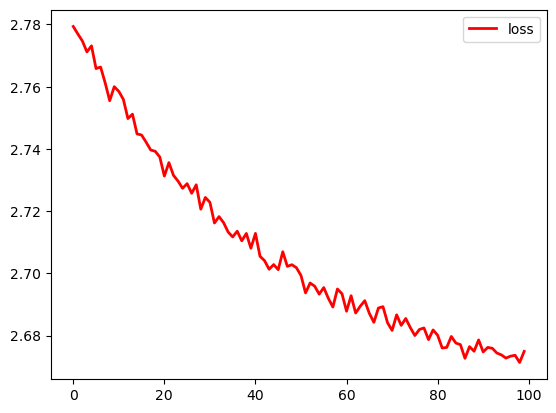

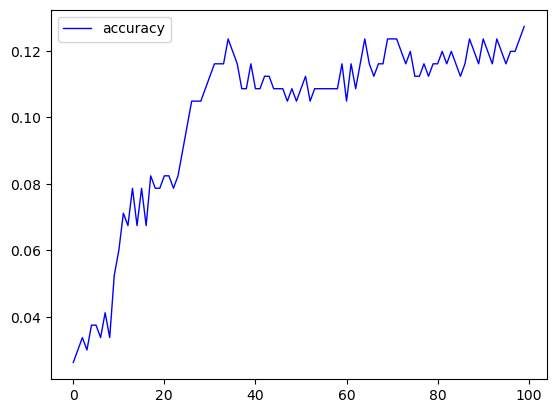

Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

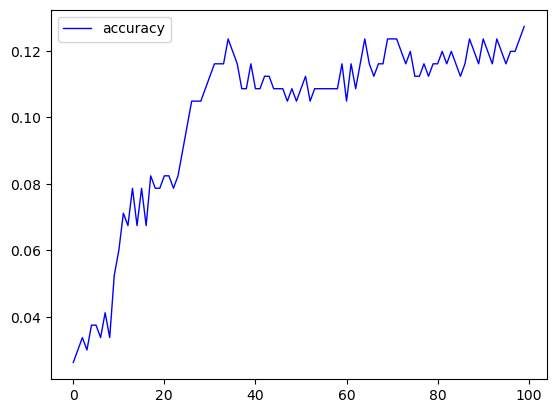

In [169]:
epochs = 100

# for plotting the training loss
history = {'losses': [], 'accuracies': []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['losses'].append(train(train_dataloader, model, loss_fn, optimizer))
    history['accuracies'].append(test(test_dataloader, model, loss_fn))
    plt.clf()
    fig1 = plt.figure()
    plt.plot(history['losses'], 'r-', lw=2, label='loss')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.clf()
    fig2 = plt.figure()
    plt.plot(history['accuracies'], 'b-', lw=1, label='accuracy')
    plt.legend()
#     display.clear_output(wait=True)
    display.display(plt.gcf())
print("Done!")